In [1]:
%matplotlib inline
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np
from scipy import signal

# import datashader as ds
# import datashader.transfer_functions as tf
import pandas as pd
import numpy as np
# import pynapple as nap


import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

na = np.array
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import h5py

In [24]:
import os

def find_h5_files(root_folder):
    h5_files = []
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for file in filenames:
            if file.endswith('.h5'):
                full_path = os.path.join(dirpath, file)
                h5_files.append(full_path)
    return h5_files

In [27]:
folder = '/mnt/server_epl/SCN1A/R1648H-export'  # replace with your root directory
h5_list = find_h5_files(folder)

for path in h5_list:
    print(path)

print(f"\nFound {len(h5_list)} HDF5 files.")

/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice2/2025-03-18T13-14-03McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice2/2025-03-18T13-31-51McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice2/2025-03-18T13-52-04McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice2/2025-03-18T13-32-32McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice1/2025-03-18T12-08-33McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice1/2025-03-18T12-39-10McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice1/2025-03-18T12-19-34McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice4/2025-03-18T15-12-04McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice4/2025-03-18T15-40-06McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice4/2025-03-18T15-28-14McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice3/2025-03-18T14-15-04McsRecording.h5
/mnt/server_epl/SCN1A/R1648H-export/18-3-25/slice3/202

In [ ]:
%%time
import os
import numpy as np
from scipy.signal import butter, lfilter, lfilter_zi
# from scipy.signal import butter, sosfilt, sosfilt_zi
from scipy.signal import butter, sosfiltfilt

def get_all_chunk_bounds(total_length, chunk_size):
    chunks = []
    for i in range(0, total_length, chunk_size):
        start = i
        end = min(i + chunk_size, total_length)
        chunks.append((start, end))
    return chunks
# Design filter (Butterworth bandpass)
def design_filter(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b = butter(order, highcut / nyq, btype='low', output='sos')#butter(order, [lowcut / nyq, highcut / nyq], btype='band', output='sos')
    return b
# file_name = '/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice2/2025-03-20T12-08-00McsRecording.h5'
file_name = '/mnt/server_epl/SCN1A/R1648H-export/21-3-25/slice6/2025-03-21T14-52-28McsRecording.h5' #'/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice4/2025-03-20T14-07-28McsRecording.h5'

# source_file = '/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice2/2025-03-20T12-08-00McsRecording.h5'
# get file info
channel_raw_data = McsPy.McsData.RawData(file_name)    
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
fs = na(analog_stream_0.channel_infos[2].sampling_frequency) # get frequency
date_time =channel_raw_data.date
n_channels=252
b = design_filter(.1, 200, fs)
subsampling_rate = 800# Hz
subsampling_step = int(fs/subsampling_rate) # 

slice_ =file_name.split('/')[-2]
name = file_name.split('/')[-1]#'2025-03-20T14-07-28McsRecording'
date = formatted = channel_raw_data.date.strftime('%d-%m-%y')
target_folder = '/home/ovinogradov/Projects/MEA-analysis/data/R1648H_filt/'
name_filtered = 'R1648H_{date}_{slice_}_{name}_filtered.h5'.format(date=date, slice_=slice_,name = name)
target_file= os.path.join(target_folder,name_filtered)
n_samples_in = analog_stream_0.timestamp_index[-1][-1]+1

chunck_size = 2000000
n_samples_out = n_samples_in // subsampling_step
n_samples_out = int(n_samples_in // subsampling_step)
#os.join '/home/ovinogradov/Projects/MEA-analysis/data'#'/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice2/2025-03-20T12-08-00McsRecording_filt.h5'

if os.path.isfile(target_file):
    print("File exists.")
    
else:
    print('Processing',file_name)
    
    with h5py.File(target_file, 'w') as write_file:
        dset = write_file.create_dataset(
            'data',
            shape=(n_samples_out, n_channels),             # start with 0 rows
            maxshape=(n_samples_out, n_channels),       # allow unlimited rows
            # chunks=(chunck_size, n_channels),   # efficient I/O chunks
            dtype='float32',
            compression='lzf'                 # optional: for smaller files
        )
        
    with h5py.File(target_file, 'a') as write_file:
        dset = write_file['data']
        # Read chunk (adapt depending on file format)
        with h5py.File(file_name, "r") as f:
            data= f['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData']
            chunnks = get_all_chunk_bounds(data.shape[1],chunck_size)        #  # Choose an optimal chunk size
            current_rows = 0
            print('total number',len(chunnks))
            for k in chunnks[:]:
                data_chunk = data[:,k[0]:k[1]]  # Process in chunks
                filtered_chunk = sosfiltfilt(b, data_chunk[:,:].T,axis=0)
                filtered_chunk = filtered_chunk[::subsampling_step,:]
                new_rows = current_rows + filtered_chunk.shape[0]
                dset[current_rows:new_rows, :] = filtered_chunk.astype(np.float32)
                current_rows = new_rows
                print(k)

    #seperately add paramters
    with h5py.File(target_file, 'a') as write_file:
        write_file['resampled_rate'] = subsampling_rate
        write_file['original_rate'] = fs
        write_file['filter'] = 'lowpass 200Hz, order=5, zero-phase, sos'
        write_file['scale'] = adc_step # votage step
        write_file['n_channels'] = n_channels
        write_file['date_time'] =  date_time.strftime('%Y-%m-%d %H:%M:%S.%f')

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 112300000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
total number 57
(0, 2000000)
(2000000, 4000000)
(4000000, 6000000)
(6000000, 8000000)
(8000000, 10000000)
(10000000, 12000000)
(12000000, 14000000)
(14000000, 16000000)
(16000000, 18000000)
(18000000, 20000000)
(20000000, 22000000)
(22000000, 24000000)
(24000000, 26000000)
(26000000, 28000000)
(28000000, 30000000)
(30000000, 32000000)
(32000000, 34000000)
(34000000, 36000000)
(36000000, 38000000)
(38000000, 40000000)
(40000000, 42000000)
(42000000, 44000000)
(44000000, 46000000)
(46000000, 48000000)


<KeysViewHDF5 ['data', 'date_time', 'filter', 'n_channels', 'original_rate', 'resampled_rate', 'scale']>


In [ ]:

        
    write_file.attrs['resampled_rate'] = subsampling_rate
    write_file.attrs['original_rate'] = fs
    write_file.attrs['filter'] = 'lowpass 200Hz, order=5, zero-phase, sos'
    write_file.attrs['scale'] = adc_step # votage step
    write_file.attrs['n_channels'] = n_channels
    write_file.attrs['date_time'] =  date_time.strftime('%Y-%m-%d %H:%M:%S.%f')

In [33]:
subsampling_rate

800

In [5]:
file_name = '/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice5/2025-03-20T15-02-51McsRecording.h5' #'/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice4/2025-03-20T14-07-28McsRecording.h5'

# source_file = '/mnt/server_epl/SCN1A/R1648H-export/20-3-25/slice2/2025-03-20T12-08-00McsRecording.h5'
# get file info
channel_raw_data = McsPy.McsData.RawData(file_name)    
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
fs = na(analog_stream_0.channel_infos[2].sampling_frequency) # get frequency
date_time =channel_raw_data.date
n_channels=252
subsampling_rate = 800# Hz
subsampling_step = int(fs/subsampling_rate) # 


slice_ =file_name.split('/')[-2]
name = file_name.split('/')[-1]#'2025-03-20T14-07-28McsRecording'
date = formatted = channel_raw_data.date.strftime('%d-%m-%y')
target_folder = '/home/ovinogradov/Projects/MEA-analysis/data/R1648H_filt/'
name_filtered = 'R1648H_{date}_{slice_}_{name}_filtered.h5'.format(date=date, slice_=slice_,name = name)
target_file= os.path.join(target_folder,name_filtered)

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 12178000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


In [34]:
adc_step

np.float64(3.0710999999999996e-08)

In [32]:
target_file

'/home/ovinogradov/Projects/MEA-analysis/data/R1648H_filt/R1648H_21-03-25_slice6_2025-03-21T14-52-28McsRecording.h5_filtered.h5'

In [30]:

# file_name = '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/2025-01-17T21-17-46McsRecording.h5'

# with h5py.File('filtered.h5', 'r') as f:
with h5py.File(target_file, 'r') as f:
    print(f['data'].shape)
    filt = f['data'][:,:]
    
# with h5py.File(file_name, "r") as f:
#     data= f['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData']
#     print(data)
#     # chunk_size = 1000  # Choose an optimal chunk size
#     data_series = data[10,:]  # Process in chunks


(4492000, 252)


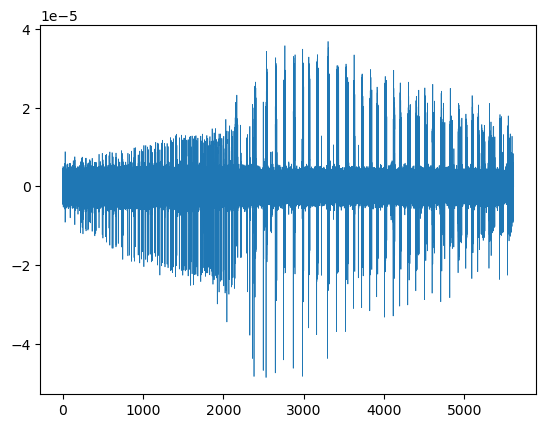

In [31]:
plt.figure()

# plt.plot(np.arange(0,len(data_series))*(1/fs),data_series*adc_step)
# plt.plot(np.arange(0,len(filt))*(1/1000),filt[:,3]*adc_step,'-');
plt.plot(np.arange(0,len(filt))*(1/subsampling_rate),filt[:,10]*adc_step,'-',linewidth = 0.5);
# plt.xlim(85,140.3)
# plt.ylim([-5e-5,8e-5])
plt.show()

(-5e-05, 8e-05)

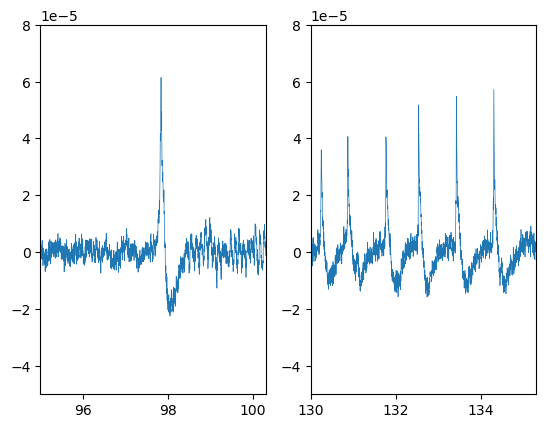

In [23]:
plt.subplot(1,3,1)
plt.plot(np.arange(0,len(filt))*(1/subsampling_rate),filt[:,10]*adc_step,'-',linewidth = 0.5);
plt.xlim(95,100.3)
plt.ylim([-5e-5,8e-5])

plt.plot(np.arange(0,len(filt))*(1/subsampling_rate),filt[:,10]*adc_step,'-',linewidth = 0.5);
plt.xlim(95,100.3)
plt.ylim([-5e-5,8e-5])

plt.subplot(1,3,2)
plt.plot(np.arange(0,len(filt))*(1/subsampling_rate),filt[:,10]*adc_step,'-',linewidth = 0.5);
plt.xlim(130,135.3)
plt.ylim([-5e-5,8e-5])